# Predicting NBA shots 
# 1. dio: Priprema i vizualizacija podataka

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt
import math
import seaborn as sns
#izvor dataseta: https://www.kaggle.com/dansbecker/nba-shot-logs

### Učitavanje podataka


In [2]:
shot_logs = pd.read_csv("archive/shot_logs.csv", sep = ",")
shot_logs.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [3]:
# dimenzije dataframea
shot_logs.shape

(128069, 21)

### Upoznavanje s datasetom
Za neke je stupce odmah očito njihovo značenje, međutim za neke treba bolje proučiti podatke i dodatno istražiti kako bi se razumjelo što ti podaci predstavljaju. <br>
**LOCATION** se odnosi na Home ili Away, odnosno je li tim igrao u svojoj saveznoj državi ili u gostima. <br>
**FINAL_MARGIN** razlika između poena oba tima u konačnom rezultatu utakmice. Ako je tim pobjedio (W), razlika je pozitivna, u suprotnom je negativna. <br>
**SHOT_NUMBER** je redni broj šuta u utakmici. <br>
**PERIOD** je četvrtina u kojoj je šut napravljen.<br>
**GAME_CLOCK** je vrijeme u toj četvrtini.<br>
**SHOT_CLOCK** je vrijeme u napadu u kojem je šut napravljen.<br>
**DRIBBLES** je broj driblova koje je igrač izveo od posjeda lopte do šutiranja lopte.<br>
**TOUCH_TIME** je vrijeme posjeda lopte igrača koji je šutirao, otkako je zaprimio loptu.<br>
**PTS_TYPE** - je li igrač pucao šut za 2 ili za 3 boda <br>
**FGM** ima vrijednot 1 ako je šut uspješan, 0 ako je igrač promašio.<br>
**PTS** označava koliko je bodova ostvario taj šut (0 ako je igrač promašio, 2 ako je zabio iz udaljenosti za 2 poena, 3 ako je zabio tricu). Iz ovog podatka vidimo da u datasetu nemamo slobodna bacanja, budući da svako uspješno slobodno bacanje donosi 1 bod.

In [4]:
# imena stupaca
shot_logs.columns.values

array(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN',
       'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES',
       'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT',
       'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST',
       'FGM', 'PTS', 'player_name', 'player_id'], dtype=object)

### Monotoni atributi
Vidimo da ni jedan atribut ne raste paralelno s brojem stupaca. Već je intuitivno vidljivo da podaci kao što su GAME_ID, CLOSEST_DEFENDER_PLAYER_ID, MATCHUP neće imati nikakav utjecaj na predikciju uspješnosti šuta.

In [5]:
shot_logs.nunique()

GAME_ID                        904
MATCHUP                       1808
LOCATION                         2
W                                2
FINAL_MARGIN                    88
SHOT_NUMBER                     38
PERIOD                           7
GAME_CLOCK                     719
SHOT_CLOCK                     241
DRIBBLES                        33
TOUCH_TIME                     313
SHOT_DIST                      448
PTS_TYPE                         2
SHOT_RESULT                      2
CLOSEST_DEFENDER               473
CLOSEST_DEFENDER_PLAYER_ID     474
CLOSE_DEF_DIST                 299
FGM                              2
PTS                              3
player_name                    281
player_id                      281
dtype: int64

### Nedostajući podatci

Vidimo da stupac SHOT_CLOCK ima jako puno nedostajućih podataka. <br>
Taj stupac predstavlja koliko je još vremena ostalo do kraja napada (u NBA-u napad traje 24 sekunde).
Redovi koji imaju NaN vrijednost za atribut SHOT_CLOCK čine 4.3% podataka u datasetu.

In [6]:
shot_logs.isna().sum()

GAME_ID                          0
MATCHUP                          0
LOCATION                         0
W                                0
FINAL_MARGIN                     0
SHOT_NUMBER                      0
PERIOD                           0
GAME_CLOCK                       0
SHOT_CLOCK                    5567
DRIBBLES                         0
TOUCH_TIME                       0
SHOT_DIST                        0
PTS_TYPE                         0
SHOT_RESULT                      0
CLOSEST_DEFENDER                 0
CLOSEST_DEFENDER_PLAYER_ID       0
CLOSE_DEF_DIST                   0
FGM                              0
PTS                              0
player_name                      0
player_id                        0
dtype: int64

### Ispravljanje nedostajućih podataka

U košarci je količina vremena koja je ostala na shot clocku vrlo bitan faktor. <br>
Ako je na shot clocku ostalo vrlo malo vremena do kraja napada kada je lopta šutirana, razumno je pretpostaviti da provedena akcija nije bila vrlo uspješna (jer se npr. obrana jako dobro postavila). Zbog toga je vjerojatnije da je igrač panično šutirao pa će i uspješnost takvih šuteva možda biti znatno manja. Ovu tvrdnju testiramo na kraju dokumenta.<br>
Iz tog razloga izbacivanje čitavog stupca SHOT_CLOCK ne dolazi u obzir. Radi očuvanja količine podataka, ne želim ni izbaciti sve redove u kojima je SHOT_CLOCK NaN. <br> 
Pogledajmo kako izgleda razdioba SHOT_CLOCK vrijednosti.

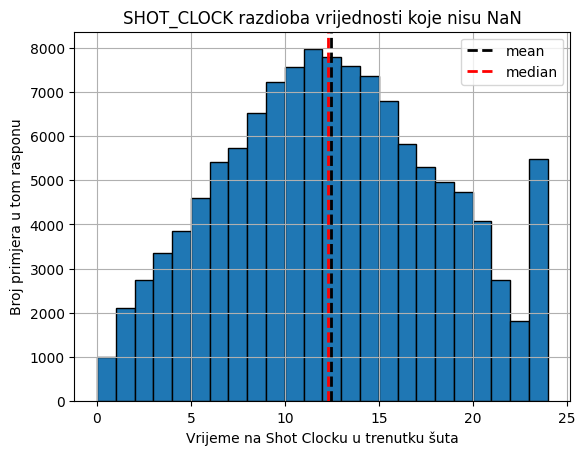

In [7]:

not_na_shotclock = shot_logs['SHOT_CLOCK'][shot_logs['SHOT_CLOCK'].notna().tolist()]
#print(not_na_shotclock)

plt.hist(not_na_shotclock, bins=24, edgecolor='black') 
plt.axvline(shot_logs['SHOT_CLOCK'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(shot_logs['SHOT_CLOCK'].median(), color='red', linestyle='dashed', linewidth=2)
plt.title('SHOT_CLOCK razdioba vrijednosti koje nisu NaN')
plt.xlabel("Vrijeme na Shot Clocku u trenutku šuta")
plt.ylabel("Broj primjera u tom rasponu")
plt.legend(["mean", "median"])
plt.grid()
plt.show()
#print(shot_logs['SHOT_CLOCK'].notna().tolist())

Vidimo da se vremena SHOT_CLOCK ravnaju po normalnoj razdiobi, s iznimkom za SHOT_CLOCK vrijednosti koje su između 23 i 24. Logično je da takvih vrijednosti ima neproporcionalno mnogo jer igrači nastoje šutirati loptu prije neko što istekne shot clock. <br>
Kako bih sačuvao podatke u kojima je SHOT_CLOCK = NaN, odlučio sam NaN vrijednosti u tim redcima zamijeniti sa brojem uzorkovanim iz normalne distribucije koja ima mean i st. dev. SHOT_CLOCK stupca. Time zadržavam originalnu distribuciju podataka. <br>
Ovo mi se čini kao bolje rješenje od zamjene svih NaN vrijednosti sa srednjom vrijednošću podataka. 
Da sam to napravio imao bih jako puno šuteva koji su pucani baš između 12 i 13 sekunde, što nije realistično.

std. dev.: 5.763265011581127 , mean: 12.453343618879694


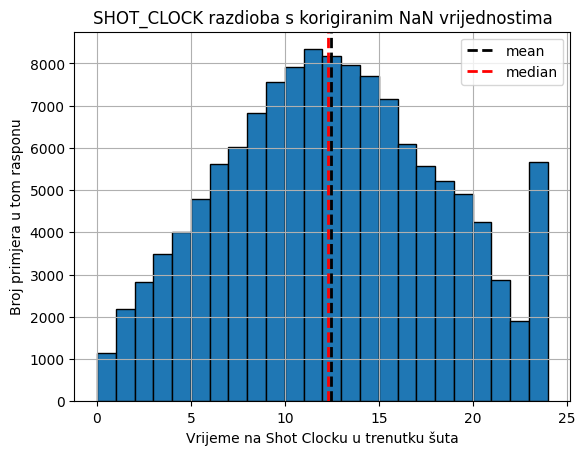

In [8]:
na_shotclock = shot_logs['SHOT_CLOCK'][shot_logs['SHOT_CLOCK'].isna().tolist()]
broj_na = len(na_shotclock)
std_deviation = shot_logs['SHOT_CLOCK'].std()
mean = shot_logs['SHOT_CLOCK'].mean()
print("std. dev.:", std_deviation,", mean:", mean)

# brojevi iz normalne razdiobe koje stavljamo umjesto NaN vrijednosti
nove_vrij = np.random.normal(mean, std_deviation, broj_na)

# generirali smo negativne vrijednosti i one koje su veće od 24 što nije realistično
# zbog toga ih pritežemo na realistične vrijednosti
for i in range(len(nove_vrij)):
    if nove_vrij[i] < 0:
        nove_vrij[i] = 0.01
    if nove_vrij[i] > 24:
        nove_vrij[i] = 23.99
        
shot_logs_tmp = shot_logs.copy()
shot_logs_tmp.loc[shot_logs_tmp.SHOT_CLOCK.isna(),'SHOT_CLOCK'] = nove_vrij

# provjera da smo stvarno eliminirali sve NaN vrijednosti
shot_logs_tmp.isna().sum()

#prikaz razdiobe
plt.hist(shot_logs_tmp['SHOT_CLOCK'], bins=24, edgecolor='black') 
plt.title('SHOT_CLOCK razdioba s korigiranim NaN vrijednostima')
plt.axvline(shot_logs_tmp['SHOT_CLOCK'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(shot_logs_tmp['SHOT_CLOCK'].median(), color='red', linestyle='dashed', linewidth=2)
plt.legend(["mean", "median"])
plt.xlabel("Vrijeme na Shot Clocku u trenutku šuta")
plt.ylabel("Broj primjera u tom rasponu")
plt.grid()
plt.show()

### Stršeći podatci

Analizirajući opis stupaca, jedan od stupaca koji ima sumnjive vrijednosti je TOUCH_TIME. U njemu je minimalna vrijednost -163.6 <br>
TOUCH_TIME bi trebao predstaljati vrijeme posjedovanja lopte prije šuta u sekundama. To vrijeme dakle nikako ne bi smjelo biti negativno, a ne bi ni trebalo biti dulje od 24 sekunde (budući da napad maksimalno može trajati 24s) <br>
Još jedan koji bi mogao imati stršeće podatke je CLOSE_DEF_DIST. U njemu vidimo da je max vrijednost preko 10 puta veća od vrijednosti koja je na 75. centilu. 

In [9]:
shot_logs_tmp.info()

# radimo opis stupaca koji imaju numeričke vrijednosti (koje nisu binarne i nisu ID)
numerical_shot_logs_tmp = shot_logs_tmp.loc[:,['FINAL_MARGIN','SHOT_NUMBER', 'PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST']]
numerical_shot_logs_tmp.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   GAME_ID                     128069 non-null  int64  
 1   MATCHUP                     128069 non-null  object 
 2   LOCATION                    128069 non-null  object 
 3   W                           128069 non-null  object 
 4   FINAL_MARGIN                128069 non-null  int64  
 5   SHOT_NUMBER                 128069 non-null  int64  
 6   PERIOD                      128069 non-null  int64  
 7   GAME_CLOCK                  128069 non-null  object 
 8   SHOT_CLOCK                  128069 non-null  float64
 9   DRIBBLES                    128069 non-null  int64  
 10  TOUCH_TIME                  128069 non-null  float64
 11  SHOT_DIST                   128069 non-null  float64
 12  PTS_TYPE                    128069 non-null  int64  
 13  SHOT_RESULT   

,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST
count,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,0.208723,6.506899,2.469427,12.448782,2.023355,2.765901,13.571504,4.123015
std,13.233267,4.713260,1.139919,5.756935,3.477760,3.043682,8.888964,2.756446
min,-53.000000,1.000000,1.000000,0.000000,0.000000,-163.600000,0.000000,0.000000
25%,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.300000
50%,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.700000,3.700000
75%,9.000000,9.000000,3.000000,16.600000,2.000000,3.700000,22.500000,5.300000
max,53.000000,38.000000,7.000000,24.000000,32.000000,24.900000,47.200000,53.200000


Promotrimo učestalost vrijednosti koje bi mogle biti stršeće. S obzirom da dataset ima preko 128000 redova, možemo izbaciti redove koji imaju negativnu vrijednost TOUCH_TIME budući da to nema nikakvog smisla. Vrijednosti kojima je TOUCH_TIME veći od 24 ima samo 4, međutim max vrijednost je svega 24.9 pa micanje tih redaka ne bi imalo osjetan utjecaj. 


TOUCH_TIME < 0:  312

TOUCH_TIME > 24:  4


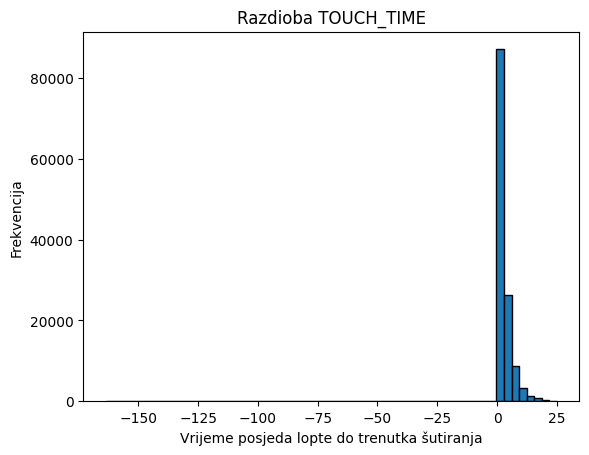

broj redaka u dataframeu nakon izbacivanja redaka sa negativnom TOUCH_TIME vrijednosti: 127757


In [10]:
# redovi s negativnom TOUCH_TIME vrijednosti čine svega 0.2% podataka.
print('\nTOUCH_TIME < 0: ', (shot_logs_tmp.TOUCH_TIME < 0).sum()) 

print('\nTOUCH_TIME > 24: ', (shot_logs_tmp.TOUCH_TIME > 24).sum())

plt.hist(shot_logs_tmp['TOUCH_TIME'], bins=60, edgecolor='black') 
plt.title('Razdioba TOUCH_TIME')
plt.xlabel("Vrijeme posjeda lopte do trenutka šutiranja")
plt.ylabel("Frekvencija")
plt.show()

# izbacivanje redaka s negativnom TOUCH_TIME
shot_logs_tmp_2 = shot_logs_tmp[shot_logs_tmp['TOUCH_TIME']>=0]
shot_logs_tmp_2 = shot_logs_tmp_2.reset_index(drop=True)
print("broj redaka u dataframeu nakon izbacivanja redaka sa negativnom TOUCH_TIME vrijednosti:", len(shot_logs_tmp_2))

<br>Razmotrimo stršeće vrijednosti za udaljenost najbližeg obrambenog igrača **CLOSE_DEF_DIST** <br>
Iako nema mnogo redaka gdje je udaljenost najbližeg obrambenog igrača veća od 25, još uvijek je moguće da obrambeni igrač bude udaljen preko 50 od igrača koji šutira. Zbog toga neću micati niti jedan redak. <br>
Proučavanje ovog stupca nam je također donijelo saznanje da je udaljenost najbližeg obrambenog igrača mjerena u stopama (feet), budući da su dimenzije NBA terena 94 x 50 feet (28.7 x 15.2 m).

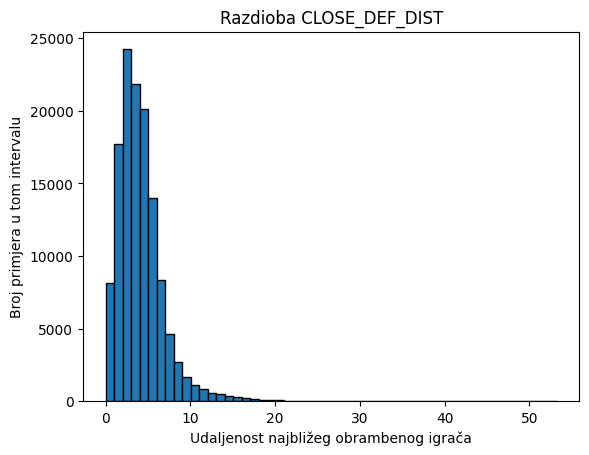

CLOSE_DEF_DIST > 21:  124
CLOSE_DEF_DIST > 23:  87
CLOSE_DEF_DIST > 24:  72
CLOSE_DEF_DIST > 25:  64


In [11]:
# razmotrimo još distribuciju CLOSE_DEF_DIST
plt.hist(shot_logs_tmp_2['CLOSE_DEF_DIST'], bins=53, edgecolor='black') 
plt.title('Razdioba CLOSE_DEF_DIST')
plt.xlabel("Udaljenost najbližeg obrambenog igrača")
plt.ylabel("Broj primjera u tom intervalu")
plt.show()
print('CLOSE_DEF_DIST > 21: ', (shot_logs_tmp.CLOSE_DEF_DIST > 21).sum())
print('CLOSE_DEF_DIST > 23: ', (shot_logs_tmp.CLOSE_DEF_DIST > 23).sum())
print('CLOSE_DEF_DIST > 24: ', (shot_logs_tmp.CLOSE_DEF_DIST > 24).sum())
print('CLOSE_DEF_DIST > 25: ', (shot_logs_tmp.CLOSE_DEF_DIST > 25).sum())

### Nekonzistentni podatci

Nakon čišćenja dataseta mogli bismo pomovno razmotriti dataset da vidimo postoje li nekonzistentni podaci. Jedini tekstualni podaci su MATCHUP, LOCATION, W, SHOT_RESULT, CLOSEST_DEFENDER i player_name. <br>
Stupci **LOCATION** (Home ili Away), **W** (W ili L) te **SHOT_RESULT** (made ili missed) bi trebali imati samo 2 moguće vrijednosti, stoga bi nam kvarilo podatke ako je netko zabunom unio drugačiju vrijednost (npr. da je došlo do tipfelera i uneseno je 'mised'). <br>
Ponovnom analizom koristeći nunique() vidljivo je da svi ti stupci imaju točno 2 vrijednosti, stoga znamo da nije došlo do nekonzistencije.

In [12]:
shot_logs_tmp_2.nunique()

GAME_ID                        904
MATCHUP                       1808
LOCATION                         2
W                                2
FINAL_MARGIN                    88
SHOT_NUMBER                     38
PERIOD                           7
GAME_CLOCK                     719
SHOT_CLOCK                    5587
DRIBBLES                        33
TOUCH_TIME                     241
SHOT_DIST                      447
PTS_TYPE                         2
SHOT_RESULT                      2
CLOSEST_DEFENDER               473
CLOSEST_DEFENDER_PLAYER_ID     474
CLOSE_DEF_DIST                 299
FGM                              2
PTS                              3
player_name                    281
player_id                      281
dtype: int64

### Pretvorbe kategoričke značajke

Prethodno spomenuti stupci Stupci LOCATION, W i SHOT_RESULT imaju tekstualne vrijednosti, a oni bi mogli biti važni za predikciju pa ih pretvaramo u numeričke binarne vrijednosti 0 i 1. <br>
Za LOCATION vrijedi: A -> 0,   H -> 1  <br>
Za W vrijedi: L -> 0,   W -> 1  <br>
Za SHOT_RESULT vrijedi: missed -> 0,   made -> 1

In [13]:
shot_logs_tmp_3 = shot_logs_tmp_2.copy()

le = LabelEncoder()
le.fit(shot_logs_tmp_3.loc[:,'LOCATION'])

shot_logs_tmp_3.loc[:,'LOCATION'] = le.transform(shot_logs_tmp_3.loc[:,'LOCATION'])

le = LabelEncoder()
le.fit(shot_logs_tmp_3.loc[:,'W'])

shot_logs_tmp_3.loc[:,'W'] = le.transform(shot_logs_tmp_3.loc[:,'W'])

# LabelEncoder pretvara made u 0, a missed u 1. To nema smisla pa koristim drugi način pretvorbe u binarne vrijednosti 
label_mapping = {'made': 1, 'missed': 0}

shot_logs_tmp_3['SHOT_RESULT'] = shot_logs_tmp_3['SHOT_RESULT'].map(label_mapping)

# provjera shot_logs_tmp_3.head(50)

### Inženjerstvo značajki

U članku je dobro istaknuto da se značajke PERIOD i GAME_CLOCK može pretvoriti u smisleniju značajku TOTAL_GAME_TIME koja bi označavala točno vrijeme od početka utakmice u sekundama. Svaki period (četvrtina) u NBA traje 12 minuta, a overtime period (kada period ima vrijednost 5 ili više) traje 5 min. GAME_CLOCK vrijednosti su zapisane u formatu minute:sekunde. <br>
Nakon ove pretvorbe ne moramo više uzimati u obzir značajke PERIOD i GAME_CLOCK čime smo smanjili dimenzionalnost dataseta.

In [14]:
tot_game_time = []

# dodavanje vremena koje je proteklo u četvrtini
for time in shot_logs_tmp_3['GAME_CLOCK']:
    #print(time)
    tmp = time.split(':')
    tot_time = int(tmp[0]) * 60  # dodavanje minuta (pretvorenih u sekunde)
    tot_time += int(tmp[1])
    #print(tot_time)
    tot_game_time.append(tot_time)
#print(len(tot_game_time))

# dodavanje vremena koje je proteklo u prijašnjim četvrtinama
for index, period in enumerate(shot_logs_tmp_3['PERIOD']):
    # period je uvijek cijeli broj između 1 i 7 (uključno)
    p = period - 1 # ako je period npr. 3, znači da je trenutno treća četverina i moramo dodati 24 minute u tot_game_time za protekle 2 četvrtine
    # za prve 4 četvrtine dodajemo 12 minuta
    if p < 5:
        tot_game_time[index] += p * 12 * 60
    else:
        overtime_p = p - 4 
        # overtime_p su protekli periodi produžetaka, svaki od njih traje 5 min
        tot_game_time[index] += 4 * 12 * 60 + overtime_p*5*60

"""  PROVJERA
for i in range(len(shot_logs_tmp_3['PERIOD'])):
    if (int(shot_logs_tmp_3['PERIOD'][i]) == 6):
        print("period: ", shot_logs_tmp_3['PERIOD'][i], " Game clock: ", shot_logs_tmp_3['GAME_CLOCK'][i])
        print(tot_game_time[i])
"""
shot_logs_tmp_4 = shot_logs_tmp_3.copy()
shot_logs_tmp_4['TOTAL_GAME_TIME'] = tot_game_time
shot_logs_tmp_4.insert(8, 'TOTAL_GAME_TIME', shot_logs_tmp_4.pop('TOTAL_GAME_TIME'))  # želim da stupac TOTAL_GAME_TIME bude pored PERIOD i GAME_CLOCK
shot_logs_tmp_4.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,TOTAL_GAME_TIME,SHOT_CLOCK,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",0,1,24,1,1,1:09,69,10.800000,...,7.7,2,1,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",0,1,24,2,1,0:14,14,3.400000,...,28.2,3,0,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",0,1,24,3,1,0:00,0,12.970793,...,10.1,2,0,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",0,1,24,4,2,11:47,1427,10.300000,...,17.2,2,0,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",0,1,24,5,2,10:34,1354,10.900000,...,3.7,2,0,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


### Uočavanje korelacije

Kod uočavanja korelacije između značajki ne koristimo stupce koji nemaju numeričke vrijednosti. Također ne koristimo značajke koje predstavljaju ID igrača ili utakmice jer ID-jevi nisu skalirani po nikakvom smislenom pravilu, osim da dva igrača nemaju isti ID. <br>
Korelacija nam govori o tome koliko su značajke međusobno linearno zavisne jedna o drugoj. To ne znači nužno da između visoko koreliranih značajki postoji kauzalnost. 

In [15]:

corr_shot_logs_tmp_4 = shot_logs_tmp_4.loc[:, ['LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER', 'TOTAL_GAME_TIME', 'SHOT_CLOCK',
                                               'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSE_DEF_DIST',
                                              'FGM', 'PTS']]  
corr_shot_logs_tmp_4.corr()

,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,TOTAL_GAME_TIME,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,FGM,PTS
LOCATION,1.000000,0.115729,0.154927,-0.003224,0.003498,0.007013,-0.014973,-0.013217,-0.001740,0.004957,0.008159,0.003516,0.008159,0.009236
W,0.115729,1.000000,0.809898,-0.004721,-0.005940,-0.020988,0.013366,0.014982,0.004929,0.013823,0.050329,0.028013,0.050329,0.054097
FINAL_MARGIN,0.154927,0.809898,1.000000,0.000735,-0.001445,-0.009316,0.011703,0.011191,0.008983,0.024077,0.058861,0.033059,0.058861,0.064867
SHOT_NUMBER,-0.003224,-0.004721,0.000735,1.000000,0.579981,-0.031131,0.141385,0.146994,0.011704,0.003055,-0.008404,-0.037666,-0.008404,-0.009712
TOTAL_GAME_TIME,0.003498,-0.005940,-0.001445,0.579981,1.000000,-0.043701,0.025085,0.019428,0.023928,0.035706,-0.010844,-0.007944,-0.010844,-0.006576
SHOT_CLOCK,0.007013,-0.020988,-0.009316,-0.031131,-0.043701,1.000000,-0.076852,-0.138207,-0.164186,-0.032614,0.094273,0.024801,0.094273,0.081841
DRIBBLES,-0.014973,0.013366,0.011703,0.141385,0.025085,-0.076852,1.000000,0.930624,-0.083039,-0.169628,-0.034825,-0.154152,-0.034825,-0.056165
TOUCH_TIME,-0.013217,0.014982,0.011191,0.146994,0.019428,-0.138207,0.930624,1.000000,-0.086741,-0.185478,-0.048072,-0.167395,-0.048072,-0.069994
SHOT_DIST,-0.001740,0.004929,0.008983,0.011704,0.023928,-0.164186,-0.083039,-0.086741,1.000000,0.741290,-0.192518,0.522937,-0.192518,-0.069781
PTS_TYPE,0.004957,0.013823,0.024077,0.003055,0.035706,-0.032614,-0.169628,-0.185478,0.741290,1.000000,-0.121745,0.414350,-0.121745,0.030011


Promatrajući tablicu korelacija odmah uočavamo da su značajke SHOT_RESULT i FGM u potpunosti korelirane, što ima smisla jer je SHOT_RESULT prije labeliranja imao vrijednosti 'made' i 'missed' koje smo predvorili u 1 i 0. Stupac FGM nam je dakle redundantan i možemo ga izbaciti. <br>

SHOT_NUMBER i TOTAL_GAME_TIME su također značajno korelirani stupci, što ima smisla jer kako vrijeme u utakmici odmiče povećava se redni broj šuteva. <br>

Vidimo da postoji značajnija korelacija između CLOSE_DEF_DIST sa značajkama SHOT_DIST i PTS_TYPE. To ima smisla jer većina obrambenih igrača tijekom napada stoji iza linije za tricu, pa ako igrač šutira s veće udaljenosti od koša (puca šut za 3 boda) vjerojatno ga nitko ne čuva. Značajke SHOT_DIST i PTS_TYPE su također visoko korelirane jer šutevi s veće udaljenosti nose više poena. <br>

Ovakav način prikazivanja korelacije nije optimalan niti oku ugodan, stoga ću za daljnju analizu napraviti heatmap. <br>
Iz heatmapa možemo uočiti još nekoliko značajnijih korelacija, ali najviše nas zanima s čime još korelira vrijednost SHOT_RESULT koju pokušavamo predvidjeti. Vidimo da je ona skoro u potpunosti korelirana sa značajkom PTS, što je očito jer se PTS odnosi na broj poena koji je šut ostvario. Dakle kad je SHOT_RESULT 1, PTS je uvijek 2 ili 3, a kad je SHOT_RESULT 1, PTS je uvijek 0. Ključno je još primijetiti da postoji nešto veća **negativna** korelacija između SHOT_DIST i SHOT_RESULT, što znači da kada igrači šutiraju s veće udaljenosti uglavnom su manje uspješni. Ovo bi moglo upućivati da će SHOT_DIST biti dobar prediktor SHOT_RESULT-a.

<Axes: >

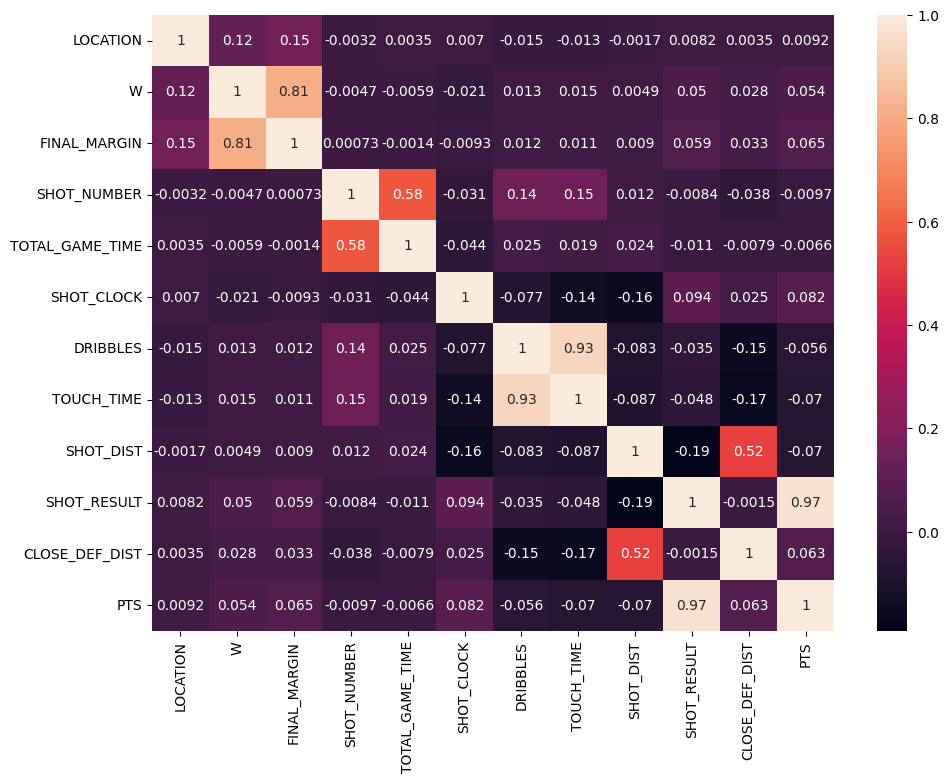

In [16]:
# koristim heatmap iz paketa seaborn zbog vrlo jednostavne implementacije i estetskih razloga
# mičem redundantne značajke iz datafamea -> one koje su visoko korelirane s drugima
if ('FGM' in list(corr_shot_logs_tmp_4.columns) or 'PTS_TYPE' in list(corr_shot_logs_tmp_4.columns)):
    corr_shot_logs_tmp_4.pop('FGM')
    corr_shot_logs_tmp_4.pop('PTS_TYPE')
heatmap_corr = corr_shot_logs_tmp_4.corr()
plt.figure(figsize=(11, 8))
sns.heatmap(heatmap_corr, annot=True)

### Utjecaj SHOT_DIST i CLOSE_DEF_DIST na uspješnost šuta

U članku je korištenjem XGBoost modela procijenjeno da su za predviđanje uspješnosti šuta najbitnije značajke SHOT_DIST i CLOSE_DEF_DIST. To također intuitivno ima smisla ako smo ikada gledali NBA ili još bolje igrali košarku. <br>l

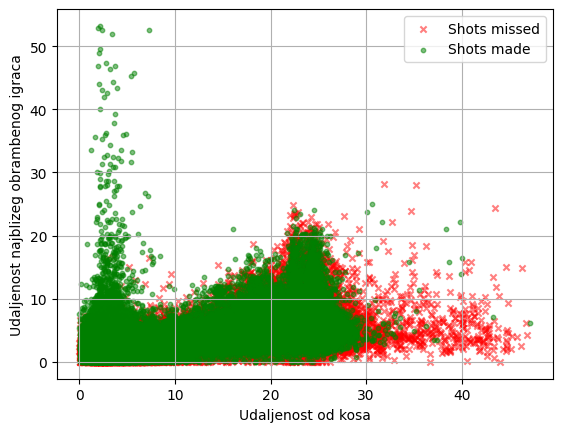

In [17]:
# graf sa 127 000 točaka nije vrlo praktično rješenje jer se na velikom dijelu grafa točke preklapaju pa interpretacija nije moguća,
# ali nam pomaže zaključiti što se događa u krajnjim slučajevima 
# zbog toga sam napisao kod tako da možemo iz dataframea uzorkovati manji broj primjera i dobiti uredniji graf 
max_size = len(corr_shot_logs_tmp_4)
random_sample = corr_shot_logs_tmp_4.sample(n=max_size)
random_sample.head()

# mask
mask_made = random_sample.SHOT_RESULT == 1

# plot
plt.scatter(random_sample.loc[~mask_made,'SHOT_DIST'], random_sample.loc[~mask_made,'CLOSE_DEF_DIST'], s=20, marker='x', alpha=0.5, c='r', label='Shots missed')
plt.scatter(random_sample.loc[mask_made,'SHOT_DIST'], random_sample.loc[mask_made,'CLOSE_DEF_DIST'], alpha=0.5, s = 10, c='g', label='Shots made')
plt.xlabel('Udaljenost od kosa')
plt.ylabel('Udaljenost najblizeg obrambenog igraca')
#plt.title('Scatter plot')
plt.grid()
plt.legend(loc='best')
plt.show()

Iz grafa možemo zaključiti da je iznimno malo vjerojatno da igrač pogodi šut ako ga puca sa preko 30ft i obrambeni igrač mu je relativno blizu. Također je iznimno vjerojatno da igrač zabije ako puca s udaljenosti manje od 10ft, a najbliži obrambeni igrač mu je udaljen preko 10ft (vjerojatno se radi o turnover situacijama koje češće završavaju pogotkom od običnih napada).

### Hipoteza: uspješnost šuta je manja kada je vrijednost na shot clocku bliža 24 jer igrač vjerojatno panično šutira

Vidimo da ova hipoteza točna jer je preciznost osjetno veća ili barem konzistentna kada shot clock nije pri kraju.

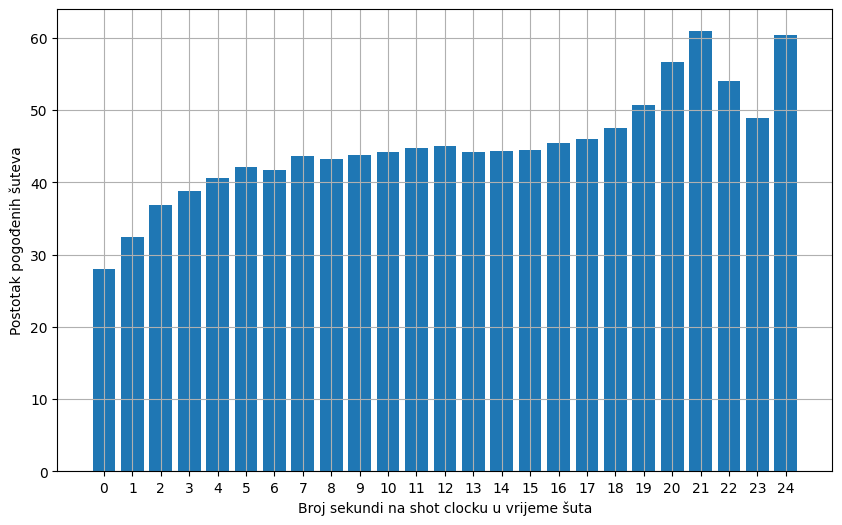

In [18]:
bar_shot_logs_tmp_4 = shot_logs_tmp_4.copy()
bar_shot_logs_tmp_4['ceil_sh_cl'] = [math.floor(i) for i in shot_logs_tmp_4['SHOT_CLOCK']]
bar_plot_df = bar_shot_logs_tmp_4[['ceil_sh_cl', 'SHOT_RESULT']].groupby(['ceil_sh_cl'], as_index=False).mean()
plt.figure(figsize=(10, 6))
plt.bar(bar_plot_df['ceil_sh_cl'], bar_plot_df['SHOT_RESULT']*100)
plt.xlabel("Broj sekundi na shot clocku u vrijeme šuta")
plt.ylabel('Postotak pogođenih šuteva')
plt.xticks(np.arange(0, 25, step=1)) 
plt.grid()
plt.show()

# 2. dio: Replikacija rezultata

## Određivanje najbitnijih značajki

### Koje značajke imaju najveću informacijsku dobit za SHOT_RESULT?

Probajmo metodom računanja informacijske dobiti (mutual information) dokučiti koje bi značajke mogle dobro predviđati uspješnost šuta.

In [19]:
kbest = SelectKBest(mutual_info_classif, k=5)

y_ = corr_shot_logs_tmp_4.loc[:, 'SHOT_RESULT']
X_ = corr_shot_logs_tmp_4.loc[:, corr_shot_logs_tmp_4.columns != 'SHOT_RESULT']

kbest.fit(X_, y_)
X_.columns[kbest.get_support()].values

array(['LOCATION', 'W', 'SHOT_CLOCK', 'SHOT_DIST', 'PTS'], dtype=object)

Prikazane značajke daju najveću informacijsku dobit, što upućuje na to da bi mogli biti dobri prediktori uspješnosti šuta (SHOT_RESULT). <br>
U članku se navodi da je korištenjem XGBoost modela ustanovljeno da su SHOT_DIST, CLOSE_DEF_DIST i TOUCH_TIME 3 najbolje značajke za predviđanje pogotka. Probajmo replicirati te rezultate. 

## Određivanje najboljih prediktora pomoću XGBoost modela

Iz dataframea smo već eliminirali stupce s vrijednostima koje nisu numeričke kada se računala korelacija između značajki. Korištenje tekstualnih podataka u modelima strojnog učenja bi zakompliciralo predviđanje, a već smo ustanovili da ti podaci nisu relevantni za predviđanje uspješnosti šuta stoga ih je najbolje jednostavno eliminirati. <br>
Korelacijska matrica također ukazuje da je značajka **PTS** vrlo visoko korelirana sa SHOT_RESULT. To ima smisla jer nam PTS govori koliko je bodova taj šut osvojio, dakle već kada je PTS 2 ili 3 znamo da je šut bio uspješan. Zbog toga nema smisla ovu značajku ostaviti u dataframeu, budući da je cilj predvidjeti rezultat šuta prije nego što znamo ishod.


In [20]:
#!pip install xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

podaci = corr_shot_logs_tmp_4.copy()

# znacajka koju predviđamo
cilj = "SHOT_RESULT"

X = podaci.drop(cilj, axis=1)
X = X.drop("PTS", axis=1)
X['LOCATION'] = X['LOCATION'].astype(int)
X['W'] = X['W'].astype(int)
y = podaci[cilj]

print("Podaci iz kojih radimo predviđanje uspjeha šuta")
X.head()



Podaci iz kojih radimo predviđanje uspjeha šuta


,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,TOTAL_GAME_TIME,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST
0,0,1,24,1,69,10.800000,2,1.9,7.7,1.3
1,0,1,24,2,14,3.400000,0,0.8,28.2,6.1
2,0,1,24,3,0,12.970793,3,2.7,10.1,0.9
3,0,1,24,4,1427,10.300000,2,1.9,17.2,3.4
4,0,1,24,5,1354,10.900000,2,2.7,3.7,1.1


Točnost predviđanja modela XGBClassifier na skupu za ispitivanje : 0.610989


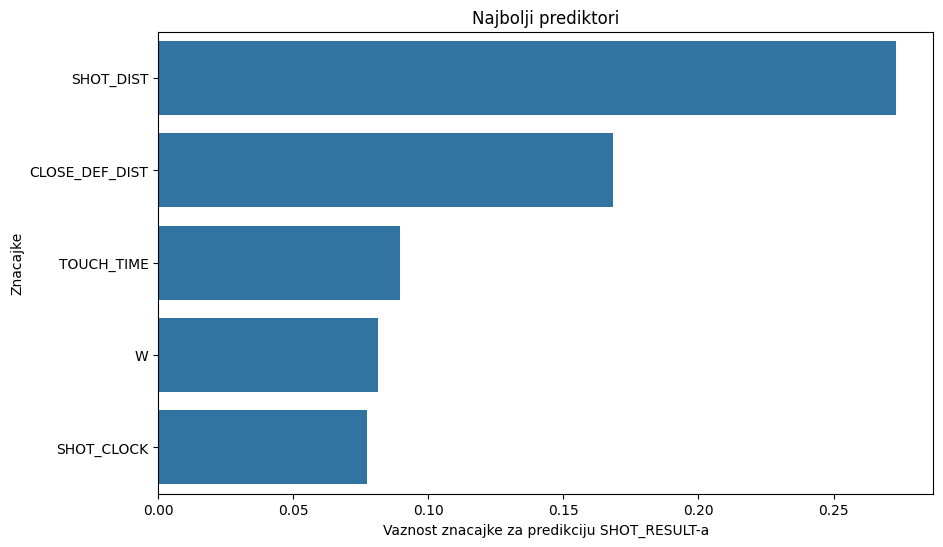

In [29]:

# odvajanje na skup za ucenje i za ispitivanje
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = XGBClassifier()
model.fit(X_train, y_train)

# predikcije
y_pred = model.predict(X_test)

# ispitivanje tocnosti predviđanja modelom 
tocnost = accuracy_score(y_test, y_pred)
print(f"Točnost predviđanja modela XGBClassifier na skupu za ispitivanje : {tocnost:.6f}")

# Koje znacajke daju najbolju predikciju
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

top_n = 5  # top 4 najbolje znacajke
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.head(top_n), y=feature_importance.head(top_n).index)
plt.title('Najbolji prediktori')
plt.xlabel('Vaznost znacajke za predikciju SHOT_RESULT-a')
plt.ylabel('Znacajke')
plt.show()



Vidimo da je poredak značajki po važnosti skoro identičan onome koji je prikazan u članku. <br>


## Predviđanje ishoda šuta

Za predviđanje ćemo koristiti i usporediti različite algoritme strojnog učenja koji su navedeni u članku. <br>
Također je spomenuto da se za ispitivanje točnosti predikcija koristilo 5% ili 10% dataseta, dok je ostatak podataka služio za učenje modela. <br>
U repliciranju rezultata ću dakle koristiti train-test razdvajanje podataka u omjeru 9:1 (smatram da se time postižu precizniji rezultati).

## 1) XGBoost

Broj primjera na kojima je model ucio: 114981
Broj primjera za ispitivanje: 12776
Točnost predviđanja modela XGBClassifier na skupu za ispitivanje : 0.610285



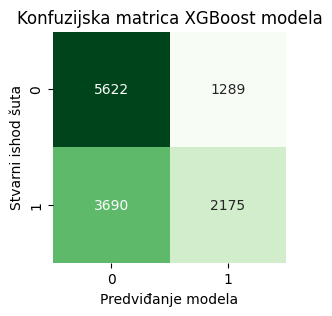

In [24]:
# odvajanje na skup za ucenje i za ispitivanje
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print("Broj primjera na kojima je model ucio:", len(X_train))
print("Broj primjera za ispitivanje:", len(X_test))

model = XGBClassifier()
model.fit(X_train, y_train)

# predikcije
y_pred = model.predict(X_test)

# ispitivanje tocnosti predviđanja modelom 
tocnost = accuracy_score(y_test, y_pred)
print(f"Točnost predviđanja modela XGBClassifier na skupu za ispitivanje : {tocnost:.6f}\n")

# Konfuzijska matrica
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotanje konfuzijske matrice
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Konfuzijska matrica XGBoost modela")
plt.xlabel("Predviđanje modela")
plt.ylabel("Stvarni ishod šuta")
plt.show()

### Poboljšavanje točnosti XGBoost modela
U članku je postignuta uspješnost predviđanja šuta od 63% koristeći XGBoost algoritam. <br>
Pogledajmo možemo li povećati točnost modela ako u datasetu zadržimo samo 3 značajke koje su najbolji prediktori.

In [25]:
smanjeni_X = X.copy()

# znacajke koje izbacujemo
columns_to_drop = ['LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER', 'TOTAL_GAME_TIME', 'DRIBBLES', 'SHOT_CLOCK']

# Drop specified columns
smanjeni_X = smanjeni_X.drop(columns=columns_to_drop)

print("Reducirani podaci iz kojih radimo predviđanje uspjeha šuta")
print(smanjeni_X.head())

# odvajanje na reduciranog skupa podataka na skup za ucenje i za ispitivanje
red_X_train, red_X_test, y_train, y_test = train_test_split(smanjeni_X, y, test_size=0.1, random_state=42)

model = XGBClassifier()
model.fit(red_X_train, y_train)

# predikcije
y_pred = model.predict(red_X_test)

# ispitivanje tocnosti predviđanja modelom 
tocnost = accuracy_score(y_test, y_pred)
print(f"\nTočnost predviđanja modela XGBClassifier koji je učen na reduciranim podacima : {tocnost:.6f}\n")

Reducirani podaci iz kojih radimo predviđanje uspjeha šuta
   TOUCH_TIME  SHOT_DIST  CLOSE_DEF_DIST
0         1.9        7.7             1.3
1         0.8       28.2             6.1
2         2.7       10.1             0.9
3         1.9       17.2             3.4
4         2.7        3.7             1.1

Točnost predviđanja modela XGBClassifier koji je učen na reduciranim podacima : 0.611537



Vidimo da točnost modela skoro uopće nije porasla. <br>
Testirajmo još možemo li povećati točnost predikcije korištenjem regularizacije u XGBoost modelu.

[0.61, 0.611, 0.613, 0.612, 0.616, 0.617, 0.619]
[0.614, 0.612, 0.615, 0.612, 0.613, 0.617, 0.615]
[0.612, 0.612, 0.615, 0.613, 0.614, 0.616, 0.615]
[0.613, 0.616, 0.613, 0.613, 0.611, 0.613, 0.618]
[0.613, 0.613, 0.613, 0.613, 0.614, 0.614, 0.617]
[0.615, 0.614, 0.615, 0.614, 0.617, 0.613, 0.619]

            0.1    0.5    1.0    2.0    5.0    10.0
L2 lambda                                          
0.1        0.610  0.614  0.612  0.613  0.613  0.615
0.5        0.611  0.612  0.612  0.616  0.613  0.614
1.0        0.613  0.615  0.615  0.613  0.613  0.615
2.0        0.612  0.612  0.613  0.613  0.613  0.614
5.0        0.616  0.613  0.614  0.611  0.614  0.617
10.0       0.617  0.617  0.616  0.613  0.614  0.613
25.0       0.619  0.615  0.615  0.618  0.617  0.619



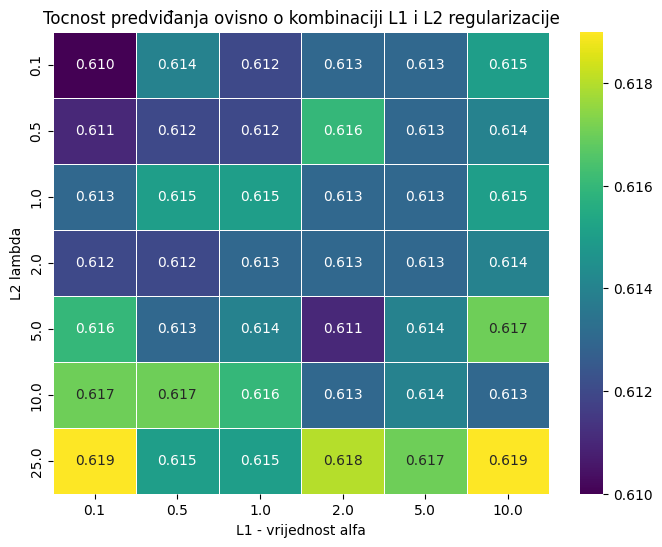

In [30]:
L1_vrij = [0.1, 0.5, 1, 2, 5, 10]
L2_vrij = [0.1, 0.5, 1, 2, 5, 10, 25]

reg_podaci = {
    'L2 lambda': L2_vrij
}

df_reg_podaci = pd.DataFrame(reg_podaci)
df_reg_podaci = df_reg_podaci.set_index('L2 lambda')

for l1 in L1_vrij:
    tocnosti_za_l1_alpha = []
    for l2 in L2_vrij:
        
        model = XGBClassifier(
            reg_alpha=l1,  # L1 regularizacija
            reg_lambda=l2  # L2 regularizacija
        )
        
        model.fit(X_train, y_train)
        
        # predikcije
        y_pred = model.predict(X_test)
        
        # ispitivanje tocnosti predviđanja modelom 
        tocnost = accuracy_score(y_test, y_pred)
        tocnosti_za_l1_alpha.append(round(tocnost, 3))
    print(tocnosti_za_l1_alpha)
    df_reg_podaci[l1] = tocnosti_za_l1_alpha
    
print()       
print(df_reg_podaci)
print()

plt.figure(figsize=(8, 6))
sns.heatmap(df_reg_podaci, annot=True, cmap='viridis', linewidths=.5, fmt=".3f")
plt.title('Tocnost predviđanja ovisno o kombinaciji L1 i L2 regularizacije')
plt.xlabel("L1 - vrijednost alfa")
plt.show()


Vidimo da smo korištenjem regulariziranog XGBoost modela koji je učen na početnom X datasetu možemo točnost predikcije povećati na 62%. 
To je vrlo blizu rezultatu koji je ostvaren u članku korištenjem istog modela.

## 2) Logistička regresija
U članku se kao prva metoda predviđanja ishoda šuta koristi L2 regularizirani model logističke regresije.<br>
Također je spomenuto da se za određene metode koristila normalizacija, stoga ću ju implementirati pomoću StandardScaler-a.<br>
Citat iz članka: *I normalized continuous data for logistic regression, SVMs, and neural networks to prevent the model from becoming ill-conditioned.*

Točnost predviđanja modela L2 regularizirane logističke regresije na skupu za ispitivanje : 0.6053



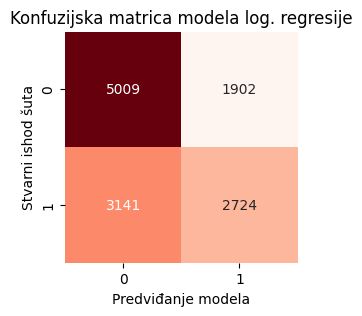

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Normalizacija znacajki
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the L2 regularized logistic regression model
model = LogisticRegression(penalty='l2', C=1.0, max_iter=1000)  # L2 regularization is the default
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

tocnost = accuracy_score(y_test, y_pred)
print(f"Točnost predviđanja modela L2 regularizirane logističke regresije na skupu za ispitivanje : {tocnost:.4f}\n")

# Konfuzijska matrica
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotanje konfuzijske matrice
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Konfuzijska matrica modela log. regresije")
plt.xlabel("Predviđanje modela")
plt.ylabel("Stvarni ishod šuta")
plt.show()

Preciznost predviđanja vlastitog modela iznosi 60.5%, što je malo više od točnosti predviđanja ishoda šuteva u članku koja iznosi 59%. Razlog tome može biti bolja priprema podataka ili nešto veći broj primjera na kojima je model treniran.

## 3) SVM
Druga metoda kojom se u članku predviđao ishod šuta su Strojevi potpornih vektora. Algoritam radi na principu maksimiziranja margine koja odvaja uspjele od neuspjelih šuteva. <br>
Učenje SVM algoritma mi je trajalo jako jako dugo, stoga sam odlučio koristiti smanjeni X dataset sa samo 3 najbitnije značajke i samo onoliko primjera za učenje koliko se koristilo u članku.

Točnost predviđanja SVM modela na skupu za ispitivanje : 0.6187



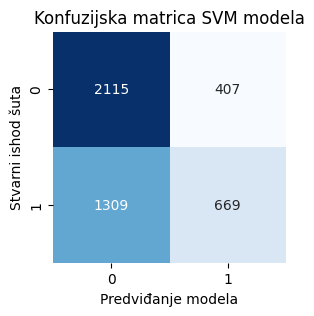

In [54]:
from sklearn.svm import SVC

# korištenjem istog random_state-a osiguravamo da se odaberu oznake y za baš te redove koje smo izabrali u manji_X 
manji_X = smanjeni_X.sample(n=45000, random_state=42)
manji_y = y.sample(n=45000, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(manji_X, manji_y, test_size=0.1, random_state=42)

# normalizacija znacajki
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# treniranje modela
model = SVC(kernel='rbf', C=1.0)
model.fit(X_train_scaled, y_train)

# predikcije
y_pred = model.predict(X_test_scaled)

tocnost = accuracy_score(y_test, y_pred)
print(f"Točnost predviđanja SVM modela na skupu za ispitivanje : {tocnost:.4f}\n")

# Konfuzijska matrica
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotanje konfuzijske matrice
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Konfuzijska matrica SVM modela")
plt.xlabel("Predviđanje modela")
plt.ylabel("Stvarni ishod šuta")
plt.show()



Vidimo da su dobiveni rezultat od skoro 62% točnosti osjetno bolji od 55% točnosti koju je postigao autor članka. Moguće je da se u članku koristila drugačija jezgra (npr. linear kernel) što je posljedično smanjilo točnost predviđanja

## 4) Neuralna mreža
U članku se koriste 2 tipa neuralnih mreža, jedna koja koristi samo sigmoidu i druga koja je tipa RELU/sigmoid. <br>
Za obje neuronske mreze specificirani su sljedeći detalji: <br>
*optimal accuracy on the training dev set was achieved when 50 hidden
neurons were used. During backpropagation, I used  regularized batch gradient descent with the same learning parameters as the network we built for HW4: batch size 1000, learning rate α = 5, λ = 0.0001.*
### 4.1) neuralna mreža koja koristi samo sigmoidu 

Epoch 1/10
41/41 [==============================] - 0s 1ms/step - loss: 1.4845 - accuracy: 0.5070
Epoch 2/10
41/41 [==============================] - 0s 2ms/step - loss: 0.6892 - accuracy: 0.5669
Epoch 3/10
41/41 [==============================] - 0s 2ms/step - loss: 0.6720 - accuracy: 0.5911
Epoch 4/10
41/41 [==============================] - 0s 1ms/step - loss: 0.6636 - accuracy: 0.6027
Epoch 5/10
41/41 [==============================] - 0s 2ms/step - loss: 0.6652 - accuracy: 0.6017
Epoch 6/10
41/41 [==============================] - 0s 2ms/step - loss: 0.6733 - accuracy: 0.5930
Epoch 7/10
41/41 [==============================] - 0s 2ms/step - loss: 0.6651 - accuracy: 0.6019
Epoch 8/10
41/41 [==============================] - 0s 1ms/step - loss: 0.6601 - accuracy: 0.6081
Epoch 9/10
41/41 [==============================] - 0s 1ms/step - loss: 0.6745 - accuracy: 0.5922
Epoch 10/10
141/141 [==============================] - 0s 1ms/step - loss: 0.6733 - accuracy: 0.5858

Test Loss: 0.673

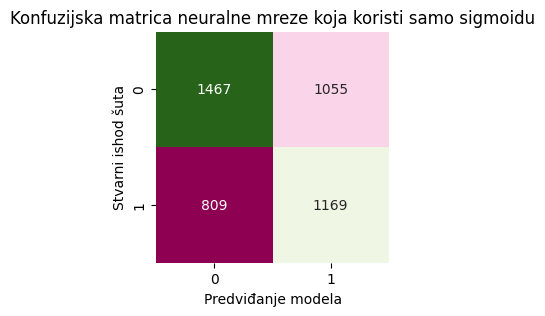

In [75]:
#!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

X_train, X_test, y_train, y_test = train_test_split(manji_X, manji_y, test_size=0.1, random_state=42)

# normalizacija znacajki
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# neuronska mreza
model = Sequential([
    Dense(50, input_dim=X_train_scaled.shape[1], activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Treniranje modela
model.fit(X_train_scaled, y_train, epochs=10, batch_size=1000, verbose=1)

# evaluacija točnosti
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\nTest Loss: {loss:.4f} \nTocnost predviđanja modela na skupu za ispitivanje: {accuracy:.4f}")

y_pred = model.predict(X_test_scaled)
#print(y_pred)
# predikcije treba zaokruziti na 0 ili 1
y_pred = np.round(y_pred).astype(int)
# Konfuzijska matrica
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotanje konfuzijske matrice
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="PiYG", cbar=False)
plt.title("Konfuzijska matrica neuralne mreze koja koristi samo sigmoidu")
plt.xlabel("Predviđanje modela")
plt.ylabel("Stvarni ishod šuta")
plt.show()


Vidimo da se gubitak smanjuje iz epohe u epohu što je dobar znak. Povećavanjem broja epoha vjerojatno bismo mogli dobiti još malo bolja predviđanja. <br>
Treniranjem ovog tipa neuralne mreže dobivamo drugačiju preciznost pri svakom pokretanju, ali generalno se kreću između 57% i 61%. To je malo bolje od preciznosti navedene u članku koja iznosi 56%. <br>

### 4.2) RELU/sigmidalna neuralna mreža

Epoch 1/10
41/41 [==============================] - 0s 2ms/step - loss: 0.6764 - accuracy: 0.5946
Epoch 2/10
41/41 [==============================] - 0s 1ms/step - loss: 0.6611 - accuracy: 0.6087
Epoch 3/10
41/41 [==============================] - 0s 2ms/step - loss: 0.6621 - accuracy: 0.6070
Epoch 4/10
41/41 [==============================] - 0s 2ms/step - loss: 0.6597 - accuracy: 0.6103
Epoch 5/10
41/41 [==============================] - 0s 1ms/step - loss: 0.6579 - accuracy: 0.6123
Epoch 6/10
41/41 [==============================] - 0s 2ms/step - loss: 0.6604 - accuracy: 0.6099
Epoch 7/10
41/41 [==============================] - 0s 2ms/step - loss: 0.6572 - accuracy: 0.6137
Epoch 8/10
41/41 [==============================] - 0s 2ms/step - loss: 0.6595 - accuracy: 0.6113
Epoch 9/10
41/41 [==============================] - 0s 2ms/step - loss: 0.6571 - accuracy: 0.6139
Epoch 10/10
141/141 [==============================] - 0s 1ms/step - loss: 0.6560 - accuracy: 0.6198

Test Loss: 0.656

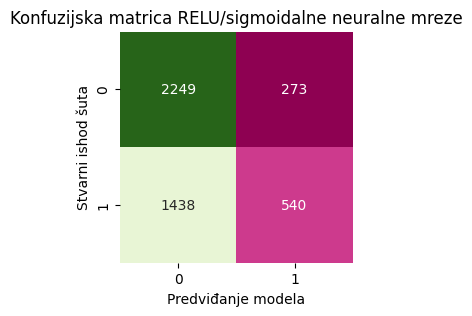

In [80]:
# za aktivacijsku fju koristimo RELU umjesto sigmoid
model = Sequential([
    Dense(50, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# treniranje modela
model.fit(X_train_scaled, y_train, epochs=10, batch_size=1000, verbose=1)

# Evaluiranje točnosti
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\nTest Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

y_pred = model.predict(X_test_scaled)
#print(y_pred)
# predikcije treba zaokruziti na 0 ili 1
y_pred = np.round(y_pred).astype(int)
# Konfuzijska matrica
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotanje konfuzijske matrice
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="PiYG", cbar=False)
plt.title("Konfuzijska matrica RELU/sigmoidalne neuralne mreze")
plt.xlabel("Predviđanje modela")
plt.ylabel("Stvarni ishod šuta")
plt.show()

Kroz nekoliko pokretanja primjećujemo da je točnost predviđanja uglavnom između 60% i 62%, što je osjetno bolje od točnosti iste neuralne mreže u članku (56%).

## 5) Naivni Bayes
Za ovaj algoritam vrijednosti značajki trebaju biti kategoričke, stoga prvo moramo podijeliti vrijednosti od 3 najbitnije značajke u 4 kategorije kao što je opisano u članku:
*>1 std dev below mean, 1 std dev below mean, 1 std dev above mean, and >1 std dev above mean*

Broj primjera na kojima je model ucio: 114981
Broj primjera za ispitivanje: 12776
Tocnost predviđanja modela naivnog Bayesa na skupu za ispitivanje: 0.5499


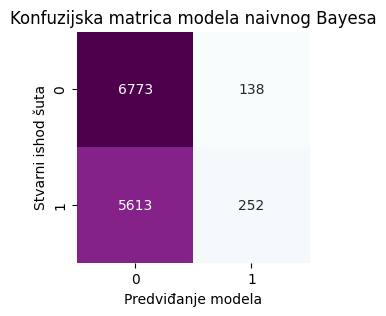

In [96]:
from sklearn.naive_bayes import MultinomialNB

# koristimo dataset smanjeni_X koji ima samo vrijednosti iz 3 najbitnije značajke: 
# SHOT_DIST, CLOSE_DEF_DIST, TOUCH_TIME

# Create a DataFrame
df = pd.DataFrame()

# funkcija za klasifikaciju znacajki
def classify_into_categories(feature_values):
    mean_val = np.mean(feature_values)
    std_dev = np.std(feature_values)
    
    categories = []
    for value in feature_values:
        if value <= (mean_val - std_dev):
            categories.append(1)   # >1 std dev below mean  ->  vrijednost 1
        elif value > (mean_val - std_dev) and value <= mean_val:
            categories.append(2) # 1 std dev below mean  ->  vrijednost 2
        elif value > mean_val and value <= (mean_val + std_dev):
            categories.append(3)  # 1 std dev above mean  ->  vrijednost 3
        else:
            categories.append(4)  # >1 std dev above mean  ->  vrijednost 4
    return categories

# Apply the classification function to each numeric feature
for feature in smanjeni_X.columns.tolist():
    df[feature] = classify_into_categories(smanjeni_X[feature])

# PROVJERA
#print(smanjeni_X.head(10))
#print(df.head(10))

# sada kad su vrijednosti znacajki raspodijeljene u 4 kategorije, 
# mozemo raditi predikciju koristeći multinomijalnog naivnog Bayesa.
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.1, random_state=42)
print("Broj primjera na kojima je model ucio:", len(X_train))
print("Broj primjera za ispitivanje:", len(X_test))

# Multinomijalni Naivni Bayes
classifier = MultinomialNB()

classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

tocnost = accuracy_score(y_test, predictions)
print(f"Tocnost predviđanja modela naivnog Bayesa na skupu za ispitivanje: {tocnost:.4f}")


conf_matrix = confusion_matrix(y_test, predictions)
# Plotanje konfuzijske matrice
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="BuPu", cbar=False)
plt.title("Konfuzijska matrica modela naivnog Bayesa")
plt.xlabel("Predviđanje modela")
plt.ylabel("Stvarni ishod šuta")
plt.show()

U članku je navedeno da je nakon treniranja na nešto više od 100k primjera, model Naivnog Bayesa imao najbolju predikciju od 54%. <br>
To odgovara ovdje dobivenom rezultatu od 55% gdje sam model učio na 114981 primjera.

## 6) Random ForestsOvo je posljednji model koji se koristio za predikciju uspješnosti šuta u članku. <br>
Algoritam treniramo na nešto više od 100k primjera iz originalnog dataseta X sa svim numerički značajkama. <br>
Specifikacije za algoritam su sljedeće:
*80 trees, 50 minimum 
leaves, and sampling without replacement*

Tocnost predviđanja Random Forests modela na skupu za ispitivanje: 0.6159


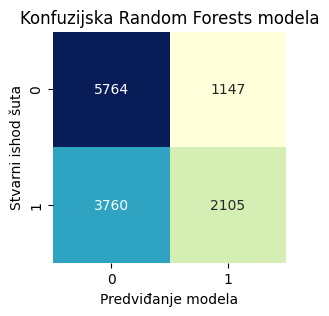

In [97]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create a Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=80, min_samples_leaf=50, bootstrap=True, random_state=42)

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test)

# Evaluate the model
tocnost = accuracy_score(y_test, predictions)
print(f"Tocnost predviđanja Random Forests modela na skupu za ispitivanje: {tocnost:.4f}")


conf_matrix = confusion_matrix(y_test, predictions)
# Plotanje konfuzijske matrice
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title("Konfuzijska Random Forests modela")
plt.xlabel("Predviđanje modela")
plt.ylabel("Stvarni ishod šuta")
plt.show()

Postignuta je točnost od 61.6%, što je identično točnosti koja je navedena u članku za isti algoritam. 